<a href="https://colab.research.google.com/github/jakecupani/marsrover/blob/main/Mars_Surface_Image_Classification_Jake_Cupani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jake Cupani
# INST767
# 5/18/22

# Research Problem

# Code

## Imports & Dependencies

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load Data

In [2]:
rootfp = "/content/drive/MyDrive/Mars Surface/"

ref_df = pd.read_csv(rootfp + "msl_synset_words-indexed.txt",header=None,delimiter='\d+',usecols=[1])
ref_df = ref_df.reset_index()
ref_df.columns = ['class','label']
ref_df

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,class,label
0,0,apxs
1,1,apxs cal target
2,2,chemcam cal target
3,3,chemin inlet open
4,4,drill
5,5,drill holes
6,6,drt front
7,7,drt side
8,8,ground
9,9,horizon


In [3]:
test_inds = pd.read_csv(rootfp + "test-calibrated-shuffled.txt",header=None,delimiter=' ')
test_inds.columns = ['filepath','class']

test_inds['use'] = ['test'] * len(test_inds)

test_inds

,filepath,class,use
0,calibrated/0830MR0036510000500684E01_DRCL.JPG,7,test
1,calibrated/0640MH0002640000203781I01_DRCL.JPG,24,test
2,calibrated/0647MH0003250050203806E01_DRCL.JPG,9,test
3,calibrated/0844MR0037590000501001I01_DRCL.JPG,7,test
4,calibrated/0618MR0026460020401253I01_DRCL.JPG,11,test
...,...,...,...
1300,calibrated/0571MH0002590000201894I01_DRCL.JPG,24,test
1301,calibrated/0840ML0037090000401385I01_DRCL.JPG,17,test
1302,calibrated/0868MH0003900000302200I01_DRCL.JPG,10,test
1303,calibrated/0568MH0002630000201882E01_DRCL.JPG,24,test


In [4]:
train_inds = pd.read_csv(rootfp + "train-calibrated-shuffled.txt",header=None,delimiter=' ')
train_inds.columns = ['filepath','class']

train_inds['use'] = ['train'] * len(train_inds)

train_inds

,filepath,class,use
0,calibrated/0077ML0005780000102730I01_DRCL.JPG,15,train
1,calibrated/0072MR0005610170103642E01_DRCL.JPG,8,train
2,calibrated/0069MR0004130000103477I01_DRCL.JPG,21,train
3,calibrated/0154ML0008510010104492E01_DRCL.JPG,8,train
4,calibrated/0019MR0000530000100138C00_DRCL.JPG,8,train
...,...,...,...
3741,calibrated/0163ML0008760050104602D01_DRCL.JPG,10,train
3742,calibrated/0072MR0005620000103655E01_DRCL.JPG,8,train
3743,calibrated/0066ML0003650000102517M00_DRCL.JPG,21,train
3744,calibrated/0157ML0008550020104531I01_DRCL.JPG,8,train


In [62]:
val_inds = pd.read_csv(rootfp + "val-calibrated-shuffled.txt",header=None,delimiter=' ')
val_inds.columns = ['filepath','class']

val_inds['use'] = ['validation'] * len(val_inds)

val_inds

,filepath,class,use
0,calibrated/0292MH0002810020103587C00_DRCL.JPG,5,validation
1,calibrated/0270MH0002530050102760I01_DRCL.JPG,5,validation
2,calibrated/0549MH0002620000201566E01_DRCL.JPG,24,validation
3,calibrated/0229MR0009720000202913E01_DRCL.JPG,0,validation
4,calibrated/0292MH0002810020103613C00_DRCL.JPG,5,validation
...,...,...,...
1635,calibrated/0486MR0011580000302944E01_DRCL.JPG,0,validation
1636,calibrated/0506MH0002240020200655I01_DRCL.JPG,8,validation
1637,calibrated/0229MR0010840000202939I01_DRCL.JPG,16,validation
1638,calibrated/0229MR0009760000202918I01_DRCL.JPG,18,validation


In [63]:
all_images_df = pd.concat([test_inds,val_inds,train_inds],ignore_index=True)

surface = [5,8,9]
all_images_df['class'] = ["Surface" if (c in surface) else "Rover" for c in all_images_df['class']]
# all_images_df['use'] = ["validation" if (x == "test") else x for x in all_images_df['use']]

all_images_df

,filepath,class,use
0,calibrated/0830MR0036510000500684E01_DRCL.JPG,Rover,test
1,calibrated/0640MH0002640000203781I01_DRCL.JPG,Rover,test
2,calibrated/0647MH0003250050203806E01_DRCL.JPG,Surface,test
3,calibrated/0844MR0037590000501001I01_DRCL.JPG,Rover,test
4,calibrated/0618MR0026460020401253I01_DRCL.JPG,Rover,test
...,...,...,...
6686,calibrated/0163ML0008760050104602D01_DRCL.JPG,Rover,train
6687,calibrated/0072MR0005620000103655E01_DRCL.JPG,Surface,train
6688,calibrated/0066ML0003650000102517M00_DRCL.JPG,Rover,train
6689,calibrated/0157ML0008550020104531I01_DRCL.JPG,Surface,train


## Directory Setup

In [69]:
def createDirectory():
  data_path = "/content/drive/MyDrive/Mars Surface/dataset/"
  folders = ['train','test','validation']
  classes = ['Surface','Rover']

  # make new directories if doesn't exist
  for f in folders:
    for i in classes:
      newpath = data_path + f + "/" + str(i)
      if not os.path.exists(newpath):
          os.makedirs(newpath)

  # defining test source and destination
  src = '/content/drive/MyDrive/Mars Surface/'
  trg = '/content/drive/MyDrive/Mars Surface/dataset/'
    
  for x in range(len(all_images_df)):
    class_label = all_images_df['class'][x]
    folder_name = all_images_df['use'][x]

    from_fp = all_images_df['filepath'][x]
    to_fp = trg + folder_name + "/" + class_label

    print(from_fp)
    print(to_fp)
    print('----------------------') 
    
    shutil.copy2(os.path.join(src,from_fp), to_fp)

In [70]:
createDirectory()

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Mars Surface/dataset/train/Rover
----------------------
calibrated/0070MR0004940020103482E01_DRCL.JPG
/content/drive/MyDrive/Mars Surface/dataset/train/Surface
----------------------
calibrated/0066ML0002960310102474E01_DRCL.JPG
/content/drive/MyDrive/Mars Surface/dataset/train/Surface
----------------------
calibrated/0017MR0000500080100080I01_DRCL.JPG
/content/drive/MyDrive/Mars Surface/dataset/train/Surface
----------------------
calibrated/0035MR0001440120100826Q01_DRCL.JPG
/content/drive/MyDrive/Mars Surface/dataset/train/Rover
----------------------
calibrated/0159MR0008620020201354I01_DRCL.JPG
/content/drive/MyDrive/Mars Surface/dataset/train/Rover
----------------------
calibrated/0019ML0000540710100352I01_DRCL.JPG
/content/drive/MyDrive/Mars Surface/dataset/train/Surface
----------------------
calibrated/0066MR0002930360103314E01_DRCL.JPG
/content/drive/MyDrive/Mars Surface/dataset/train/Surface
--------

## Images

In [76]:
data_dir = pathlib.Path(rootfp + "/calibrated")

data_dir

PosixPath('/content/drive/MyDrive/Mars Surface/calibrated')

In [77]:
print("Number of Images: ",len(list(data_dir.glob('*.JPG'))))

Number of Images:  6737


## TensorFlow Models

In [152]:
batch_size = 32
img_height = 256
img_width = 256

data_dir = "/content/drive/MyDrive/Mars Surface/dataset/train"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3746 files belonging to 2 classes.
Using 2810 files for training.


In [153]:
data_dir = "/content/drive/MyDrive/Mars Surface/dataset/validation"

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1640 files belonging to 2 classes.
Using 410 files for validation.


In [154]:
class_names = train_ds.class_names
print(class_names)

['Rover', 'Surface']


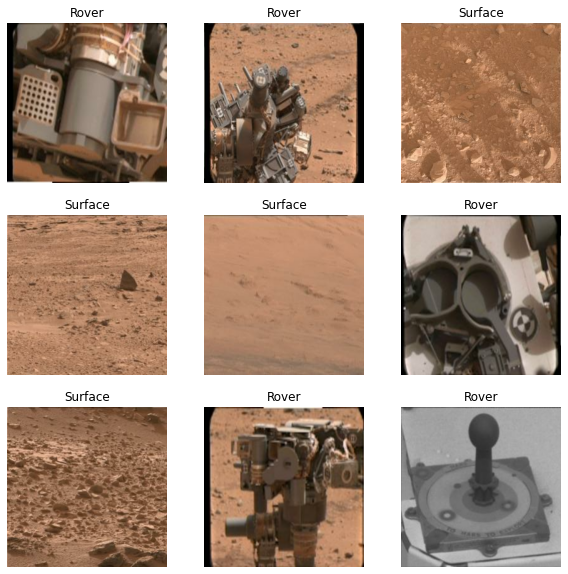

In [155]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [156]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [157]:
normalization_layer = layers.Rescaling(1./255)

In [158]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [159]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    
  ]
)

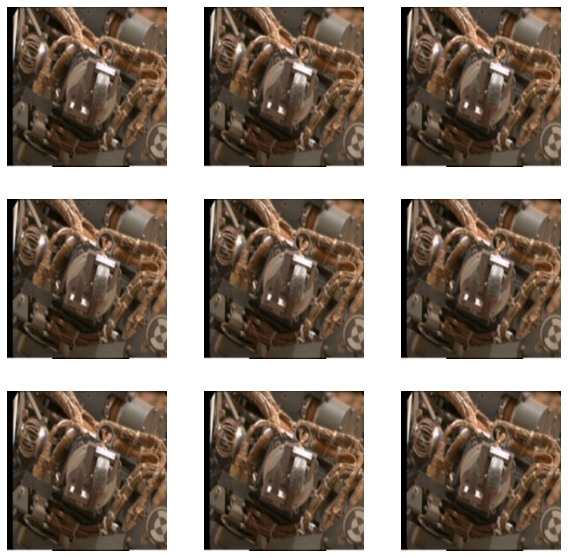

In [160]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [161]:
num_classes = len(class_names)

# Model distillation research

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'), # Reduce size
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5), # Increase to 0.5
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [162]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [163]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                

In [164]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
88/88 [==============================] - 6s 57ms/step - loss: 0.7402 - accuracy: 0.7598 - val_loss: 0.3667 - val_accuracy: 0.8829
Epoch 2/15
88/88 [==============================] - 4s 47ms/step - loss: 0.5165 - accuracy: 0.9110 - val_loss: 0.3530 - val_accuracy: 0.8732
Epoch 3/15
88/88 [==============================] - 4s 47ms/step - loss: 0.4208 - accuracy: 0.9452 - val_loss: 0.4330 - val_accuracy: 0.7976
Epoch 4/15
88/88 [==============================] - 4s 47ms/step - loss: 0.3874 - accuracy: 0.9438 - val_loss: 0.3117 - val_accuracy: 0.9000
Epoch 5/15
88/88 [==============================] - 4s 47ms/step - loss: 0.3387 - accuracy: 0.9523 - val_loss: 0.2739 - val_accuracy: 0.9098
Epoch 6/15
88/88 [==============================] - 4s 47ms/step - loss: 0.3054 - accuracy: 0.9601 - val_loss: 0.3390 - val_accuracy: 0.9488
Epoch 7/15
88/88 [==============================] - 4s 47ms/step - loss: 0.2427 - accuracy: 0.9527 - val_loss: 0.2694 - val_accuracy: 0.9024
Epoch 8/15
88

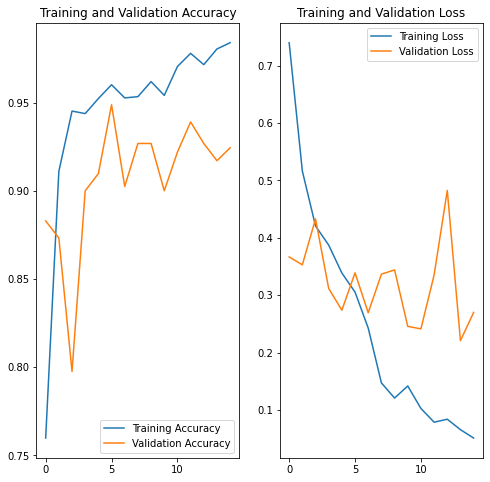

In [165]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# References



1.   Wagstaff, K., Lu, Y., Stanboli, A., Grimes, K., Gowda, T., & Padams, J. (2018, April). Deep Mars: CNN classification of mars imagery for the PDS imaging atlas. In Proceedings of the AAAI Conference on Artificial Intelligence (Vol. 32, No. 1).
2. Alice Stanboli, & Kiri Wagstaff. (2017). Mars surface image (Curiosity rover) labeled data set (1.0.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.1049137

3. 


